In [2]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../src')
import monte_carlo as mc
import black_scholes as bs
import binomial_tree as bt
import payoff as po


For constant volatility and intrest rate, we have several ways of estimating the option price: using binimial trees, monte-carlo estimation or the closed-form Black-Scholes formulae. Let us check they all agree e.g. American/European call option on a non-dividend-yielding underlying with strike K=100, expiry T=1year, intrest 5% p.a., underlying volatiliy 20%/sqrt{year}

In [23]:
Srange = np.linspace(50,150,30)
K = 100
T = 1
r = 0.05
sigma = 0.2
payoff = lambda S:po.payoff_call(S,K)
price_mc_1e1 = []
price_mc_1e2 = []
price_mc_1e3 = []
price_bt_1step = []
price_bt_10step = []
price_bt_100step = []
price_bs = []
for S0 in Srange:
    price_mc_1e1.append(mc.MC_price(S0,r,sigma,T,T,payoff,10**1))
    price_mc_1e2.append(mc.MC_price(S0,r,sigma,T,T,payoff,10**2))
    price_mc_1e3.append(mc.MC_price(S0,r,sigma,T,T,payoff,10**3))
    price_bt_1step.append(bt.eval_option_tree(S0,K,r,sigma,1,1,'call','european'))
    price_bt_10step.append(bt.eval_option_tree(S0,K,r,sigma,1,10,'call','european'))
    price_bt_100step.append(bt.eval_option_tree(S0,K,r,sigma,1,100,'call','european'))
    price_bs.append(bs.bs_formula_price(S0, K, r, 0,sigma, T, 'call'))
price_mc_1e1 = np.array(price_mc_1e1)
price_mc_1e2 = np.array(price_mc_1e2)
price_mc_1e3 = np.array(price_mc_1e3)
price_bt_1step = np.array(price_bt_1step)
price_bt_10step = np.array(price_bt_10step)
price_bt_100step = np.array(price_bt_100step)
price_bs = np.array(price_bs)

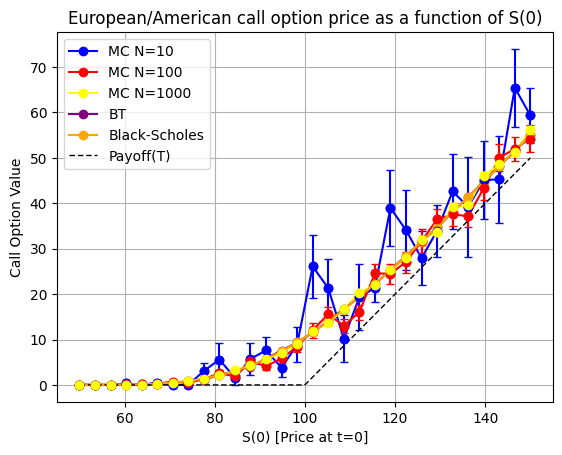

In [5]:
plt.plot(Srange, price_mc_1e1[:,0], marker='o',color='blue',label='MC N=10')
plt.errorbar(Srange, price_mc_1e1[:,0], yerr=price_mc_1e1[:,1], fmt='o', color='blue', capsize=3)
plt.plot(Srange, price_mc_1e2[:,0], marker='o',color='red',label='MC N=100')
plt.errorbar(Srange, price_mc_1e2[:,0], yerr=price_mc_1e2[:,1], fmt='o', color='red', capsize=3)
plt.plot(Srange, price_mc_1e3[:,0], marker='o',color='yellow',label='MC N=1000')
plt.errorbar(Srange, price_mc_1e3[:,0], yerr=price_mc_1e3[:,1], fmt='o', color='yellow', capsize=3)
# plt.plot(Srange, price_bt_1step, marker='o',color='green',label='BT 1 step')
plt.plot(Srange, price_bt_10step, marker='o',color='purple',label='BT')
plt.plot(Srange, price_bs, marker='o',color='orange',label='Black-Scholes')
Srange_fine = np.linspace(50,150,300)
plt.plot(Srange_fine, np.maximum(Srange_fine-K,0),color='black',label='Payoff(T)',linewidth=1,dashes=(4,2))
plt.xlabel("S(0) [Price at t=0]")
plt.ylabel("Call Option Value")
plt.title("European/American call option price as a function of S(0)")
plt.legend()
plt.grid(True)

To better see the covergence, let us plot

$\Delta P_i = \text{abs} \left(1-\frac{P_i}{P_{\text{\tiny BS}}} \right)$ for $i={\text{BT},\text{MC}}$

For MC estimation based on $N=10,10^3$ points and BT based on $N=10,100$ step.

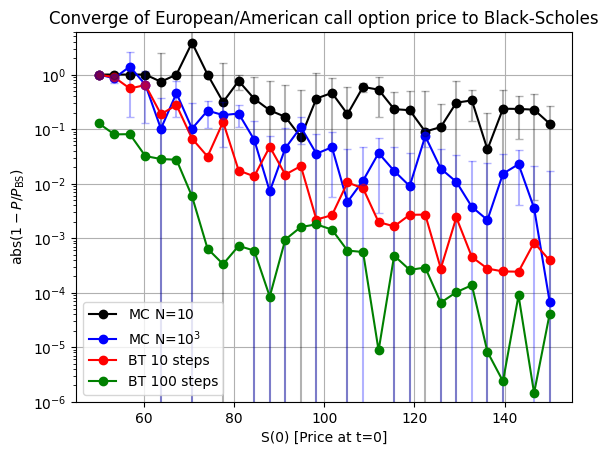

In [38]:
plt.plot(Srange,np.abs(1-price_mc_1e1[:,0]/price_bs), marker='o',color='black',label=r'MC N=$10$')
plt.errorbar(Srange, np.abs(1-price_mc_1e1[:,0]/price_bs), yerr=abs(price_mc_1e1[:,1]/price_bs), fmt='o', color='black', capsize=3,alpha=0.3)
plt.plot(Srange,np.abs(1-price_mc_1e3[:,0]/price_bs), marker='o',color='blue',label=r'MC N=$10^3$')
plt.errorbar(Srange, np.abs(1-price_mc_1e3[:,0]/price_bs), yerr=abs(price_mc_1e3[:,1]/price_bs), fmt='o', color='blue', capsize=3,alpha=0.3)
plt.plot(Srange,np.abs(1-price_bt_10step/price_bs), marker='o',color='red',label=r'BT 10 steps')
plt.plot(Srange,np.abs(1-price_bt_100step/price_bs), marker='o',color='green',label=r'BT 100 steps')
plt.yscale('log')   # log scale on y-axis
plt.ylim(0.000001, 6) 
plt.xlabel("S(0) [Price at t=0]")
plt.ylabel(r'$\text{abs}\left( 1-P/P_{\text{BS}}\right)$')
plt.title("Converge of European/American call option price to Black-Scholes")
plt.legend()
plt.grid(True)

Clearly a nice agreement with all the methods, with the MC method converging on the right result with enough statistics. 

We can also plot the dependence of the price on the strike price K for a fixed present value S0=100.

In [5]:
Krange = np.linspace(50,150,30)
S0 = 100
T = 1
r = 0.05
sigma = 0.2
payoff = lambda S:po.payoff_call(S,K)
price_mc_1e1 = []
price_mc_1e2 = []
price_mc_1e3 = []
price_bt_1step = []
price_bt_10step = []
price_bs = []
for K in Krange:
    price_mc_1e1.append(mc.MC_price(S0,r,sigma,T,T,payoff,10**1))
    price_mc_1e2.append(mc.MC_price(S0,r,sigma,T,T,payoff,10**2))
    price_mc_1e3.append(mc.MC_price(S0,r,sigma,T,T,payoff,10**3))
    price_bt_1step.append(bt.eval_option_tree(S0,K,r,sigma,1,1,'call','european'))
    price_bt_10step.append(bt.eval_option_tree(S0,K,r,sigma,1,10,'call','european'))
    price_bs.append(bs.bs_formula_price(S0, K, r, 0,sigma, T, 'call'))
price_mc_1e1 = np.array(price_mc_1e1)
price_mc_1e2 = np.array(price_mc_1e2)
price_mc_1e3 = np.array(price_mc_1e3)
price_bt_1step = np.array(price_bt_1step)
price_bt_10step = np.array(price_bt_10step)
price_bs = np.array(price_bs)

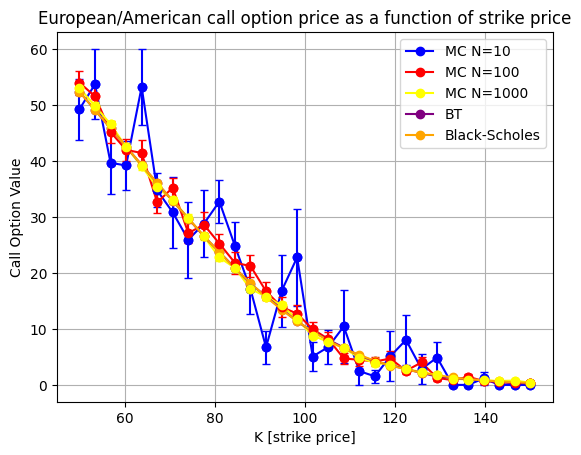

In [7]:
plt.plot(Krange, price_mc_1e1[:,0], marker='o',color='blue',label='MC N=10')
plt.errorbar(Krange, price_mc_1e1[:,0], yerr=price_mc_1e1[:,1], fmt='o', color='blue', capsize=3)
plt.plot(Krange, price_mc_1e2[:,0], marker='o',color='red',label='MC N=100')
plt.errorbar(Krange, price_mc_1e2[:,0], yerr=price_mc_1e2[:,1], fmt='o', color='red', capsize=3)
plt.plot(Krange, price_mc_1e3[:,0], marker='o',color='yellow',label='MC N=1000')
plt.errorbar(Krange, price_mc_1e3[:,0], yerr=price_mc_1e3[:,1], fmt='o', color='yellow', capsize=3)
# plt.plot(Krange, price_bt_1step, marker='o',color='green',label='BT 1 step')
plt.plot(Krange, price_bt_10step, marker='o',color='purple',label='BT')
plt.plot(Krange, price_bs, marker='o',color='orange',label='Black-Scholes')
plt.xlabel("K [strike price]")
plt.ylabel("Call Option Value")
plt.title("European/American call option price as a function of strike price")
plt.legend()
plt.grid(True)

Good agreement again, and the expected behaviour - moving further in (out) of the money by decreasing (increasing) K leads to a price increase (decrease).

Now let proceed to put option - where things are more interesting, since even for non-divident-yielding underlying, European and American puts behave differently. 
Let us calculate using binomial trees the price of American and European put options on a non-dividend-yielding underlying with strike K=100, intrest 5% p.a., underlying volatiliy 20%/sqrt{year} and expiry T=1year and T=5year.

In [40]:
Srange = np.linspace(50,150,30)
K = 100
T1 = 1
T2 = 5
r = 0.05
sigma = 0.2

price_US_1year = []
price_US_5year = []
price_EU_1year = []
price_EU_5year = []

for S0 in Srange:

    price_US_1year.append(bt.eval_option_tree(S0,K,r,sigma,T1,100,'put','american'))
    price_US_5year.append(bt.eval_option_tree(S0,K,r,sigma,T2,100,'put','american'))
    price_EU_1year.append(bt.eval_option_tree(S0,K,r,sigma,T1,100,'put','european'))
    price_EU_5year.append(bt.eval_option_tree(S0,K,r,sigma,T2,100,'put','european'))
    

price_US_1year = np.array(price_US_1year)
price_US_5year = np.array(price_US_5year)
price_EU_1year = np.array(price_EU_1year)
price_EU_5year = np.array(price_EU_5year)

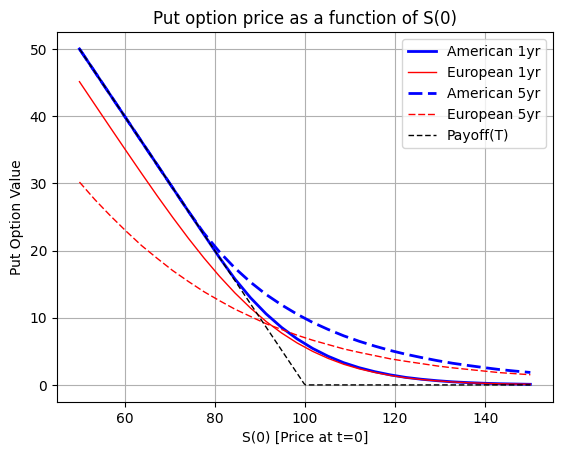

In [41]:
plt.plot(Srange, price_US_1year, marker='',markersize=4,label="American 1yr", linewidth=2,color='blue')
plt.plot(Srange, price_EU_1year, marker='',markersize=4,label="European 1yr", linewidth=1,color='red')
plt.plot(Srange, price_US_5year, marker='',markersize=4,label="American 5yr", linewidth=2,dashes=(5,2),color='blue')
plt.plot(Srange, price_EU_5year, marker='',markersize=4,label="European 5yr", linewidth=1,dashes=(5,2),color='red')
Srange_fine = np.linspace(50,150,300)
plt.plot(Srange_fine, np.maximum(K-Srange_fine,0),color='black',label='Payoff(T)',linewidth=1,dashes=(4,2))
plt.xlabel("S(0) [Price at t=0]")
plt.ylabel("Put Option Value")
plt.title("Put option price as a function of S(0)")
plt.legend()
plt.grid(True)

Interesting! We find that for deep ITM european put option, its price decrease with expiry time for a fixed S(0).  With a longer expiry time, the position has a long time to drift and spread to an OTM position at expiry. Shorter expiry - larger chances of staying ITM. Conversly, if the starting position is OTM, longer expiry increases the price since the underlying spreads the lower values and the chances of an ITM position at expiry increase.
For american put options, deep ITM positions asymptote to the payoff due to the possibilty of early exercise (ie no reason to wait and let the chances of profit decrease), while OTM positions gain the expected time value.

Let us slice things diffently and plot the price of a european put option as a function of expiry date T for a fixed S0={60,120}, K=100, intrest 5% p.a., and underlying volatiliy {20,40}{%/sqrt(year)}.

In [74]:
Trange = np.linspace(1/12,5,30)
K = 100
S0_low = 60
S0_high = 120
r = 0.05
sigma = 0.2

price_EU_low_02 = []
price_EU_high_02 = []
price_EU_low_04 = []
price_EU_high_04 = []

for T in Trange:

    price_EU_low_02.append(bt.eval_option_tree(S0_low,K,r,sigma,T,100,'put','european'))
    price_EU_high_02.append(bt.eval_option_tree(S0_high,K,r,sigma,T,100,'put','european'))
    price_EU_low_04.append(bt.eval_option_tree(S0_low,K,r,2*sigma,T,100,'put','european'))
    price_EU_high_04.append(bt.eval_option_tree(S0_high,K,r,2*sigma,T,100,'put','european'))
    

price_EU_low_02 = np.array(price_EU_low_02)
price_EU_high_02 = np.array(price_EU_high_02)
price_EU_low_04 = np.array(price_EU_low_04)
price_EU_high_04 = np.array(price_EU_high_04)

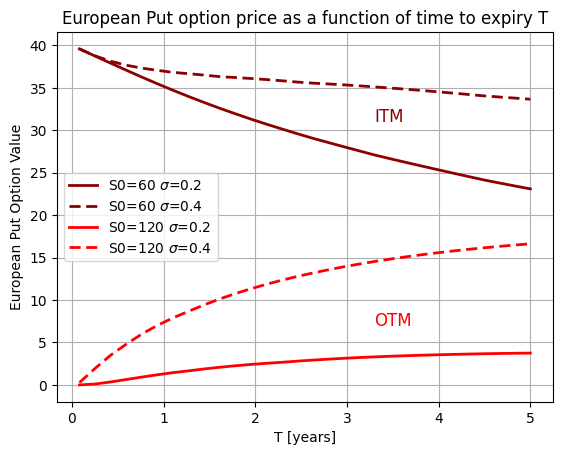

In [75]:
plt.plot(Trange, price_EU_low_02, label=r'S0=60 $\sigma$=0.2', linewidth=2,color='darkred')
plt.plot(Trange, price_EU_low_04, label=r'S0=60 $\sigma$=0.4', linewidth=2,dashes=(4,2),color='darkred')
plt.plot(Trange, price_EU_high_02, label=r'S0=120 $\sigma$=0.2', linewidth=2,color='red')
plt.plot(Trange, price_EU_high_04, label=r'S0=120 $\sigma$=0.4', linewidth=2,dashes=(4,2),color='red')
plt.xlabel("T [years]")
plt.ylabel("European Put Option Value")
plt.title("European Put option price as a function of time to expiry T")
plt.legend()
plt.text(3.3, 31, "ITM", fontsize=12, color="darkred")
plt.text(3.3, 7, "OTM", fontsize=12, color="red")
plt.grid(True)

For ITM position, smaller volatility implies more certainty, and larger expiry date is penalized by the exponential factor. This gets countered when the volatility is increased and the underlying get more spread, increasing the chances of even deeper ITM position at expiry. The overall effect is to reduce the sensitivity of the price to the expiry date.
For OTM position, larger volatility means larger spread and higher chances of reaching ITM position at expiry, there the sensitivity to expiry date increases.

To demonstrate the effect of volatility, let us consider another slicing: we plot the price of a european put option as a function of volatility for a fixed S0={60,120}, K=100, intrest 5% p.a., and expiry date {1,5} years.

In [98]:
sigmarange = np.linspace(0.01,0.4,50)
K = 100
S0_low = 60
S0_high = 120
r = 0.05
T_low = 1
T_high = 5

price_EU_low_1 = []
price_EU_high_1 = []
price_EU_low_5 = []
price_EU_high_5 = []

for sigma in sigmarange:

    price_EU_low_1.append(bt.eval_option_tree(S0_low,K,r,sigma,T_low,100,'put','european'))
    price_EU_high_1.append(bt.eval_option_tree(S0_high,K,r,sigma,T_low,100,'put','european'))
    price_EU_low_5.append(bt.eval_option_tree(S0_low,K,r,sigma,T_high,100,'put','european'))
    price_EU_high_5.append(bt.eval_option_tree(S0_high,K,r,sigma,T_high,100,'put','european'))
    

price_EU_low_1 = np.array(price_EU_low_1)
price_EU_high_1 = np.array(price_EU_high_1)
price_EU_low_5 = np.array(price_EU_low_5)
price_EU_high_5 = np.array(price_EU_high_5)

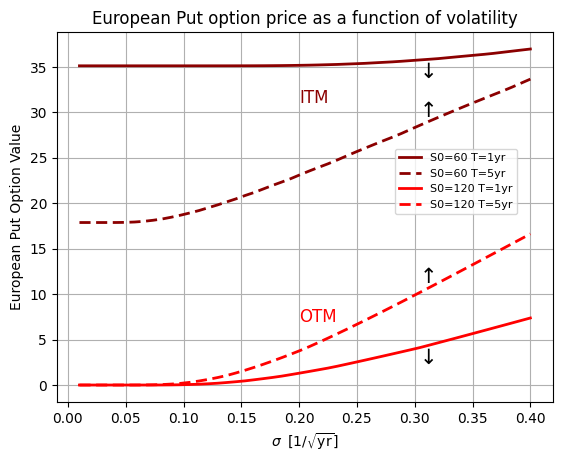

In [132]:
plt.plot(sigmarange, price_EU_low_1, label='S0=60 T=1yr', linewidth=2,color='darkred')
plt.plot(sigmarange, price_EU_low_5, label='S0=60 T=5yr', linewidth=2,dashes=(4,2),color='darkred')
plt.plot(sigmarange, price_EU_high_1, label='S0=120 T=1yr', linewidth=2,color='red')
plt.plot(sigmarange, price_EU_high_5, label='S0=120 T=5yr', linewidth=2,dashes=(4,2),color='red')
plt.xlabel(r'$\sigma\;\; [1/\sqrt{\text{yr}}]$')
plt.ylabel("European Put Option Value")
plt.title("European Put option price as a function of volatility")
plt.legend(loc="upper left", bbox_to_anchor=(0.67, 0.7),fontsize=8)
plt.text(0.2, 31, "ITM", fontsize=12, color="darkred")
plt.text(0.2, 7, "OTM", fontsize=12, color="red")
plt.text(0.3, 29.5, r'$\uparrow$', fontsize=15, color="black")
plt.text(0.3, 33.8, r'$\downarrow$', fontsize=15, color="black")
plt.text(0.3, 11.2, r'$\uparrow$', fontsize=15, color="black")
plt.text(0.3, 2.3, r'$\downarrow$', fontsize=15, color="black")
plt.grid(True)

This is consistent with what we saw in the previous plots. For ITM position, at low volatility the price is dominated by the exponential factor and larger expiry means larger price suppresion. In this example,

$\lim_{\sigma \to 0}P = 40\times \exp[-r\,T]\,.$

At larger volatilities, this effect is countered by the possibilty of larger payoff, namely deeper ITM positions due to the larger spread, and the sensitivity to the expiry time decreases, ie the two curves are nearer to each other for larger values of $\sigma$ (see arrows).

The OTM position is clear. Low volaitilies implies staying OTM (independently of expiry time) and zero value. For larger volatilites, larger expiry times increases the chances of ending up ITM, and the sensitivity to the expiry time increase, ie the two curves are further away from each other for larger values of $\sigma$ (see arrows).